In [1]:
import os
from functools import partial

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import poisson, norm

Define parameters of the model.

In [2]:
n_observed = 20000
n_simulated = 10*n_observed

batch_size = 64
learning_rate = 0.01
lambda_gradient = 0.05# Gradient penalty
lambda_entropy = 5. # Entropy penalty
obs_poisson_rate = 7. # Poisson rate of the observed data
nominal_poisson_rate = 5 # Poisson rate for the nominal data set of simulation
prop_initial_mu = np.log(5) # Initial mu of the proposal distribution 
prop_initial_log_sigma = np.log(.3) # Inintial log(sigma) of the proposal distribution
beta1 = 0.5
beta2 = 0.5
critic_steps = 100
count_steps = 300+1

#For reproducibility 
tf.set_random_seed(2210)
np.random.seed(2210)

In [3]:
def glorot_uniform(fan_in, fan_out, scale=0.1):
    s = scale * np.sqrt(6. / (fan_in + fan_out))
    return np.random.rand(fan_in, fan_out) * 2 * s - s

Generate observed samples and define simulator.

In [4]:
# Generate observed samples
obs_samples = poisson.rvs(obs_poisson_rate,size=n_observed)

# Generate simulated nominal samples
sim_samples_nominal = poisson.rvs(nominal_poisson_rate,size=[n_simulated,1])
pmf_nominal = poisson.pmf(sim_samples_nominal,nominal_poisson_rate) # nominal probability mass of samples

# Define simulator/reweighter
def simulator(X):
    indices = np.random.choice(n_simulated,size=X.shape[0],replace=True)
    sim_samples = sim_samples_nominal[indices]
    pmf_simulator = poisson.pmf(sim_samples,np.exp(X))
    sim_weights = pmf_simulator/pmf_nominal[indices]
    return sim_samples, sim_weights

Define AVO model.

In [5]:
batch_shape = (batch_size, 1)
critic_shape = (batch_size, 1)

# Placeholder for real distribution
X_real = tf.placeholder(tf.float32,shape=batch_shape)

# Define proposal parameters Psi
with tf.variable_scope('proposal'):
    mu = tf.get_variable('mu', shape=(), initializer=tf.constant_initializer(prop_initial_mu))
    # We use logarithm of sigma since sigma >= 0 in order to stretch it over the real line
    lg_sigma = tf.get_variable('lg_sigma', shape=(), initializer=tf.constant_initializer(prop_initial_log_sigma))

# Define proposal distribution q
prop_distribution = tf.contrib.distributions.Normal(loc=mu, scale=tf.exp(lg_sigma))
sample_proposal = tf.stop_gradient(prop_distribution.sample(sample_shape=batch_shape))

# Compute the log probability for the parameters 
log_prob_prop = prop_distribution.log_prob(sample_proposal)
#Analytic differential entropy for the proposal distribution
entropy_proposal = lg_sigma 

# Placeholder for simulated distribution and their weights
X_sim = tf.placeholder(tf.float32,shape=batch_shape)
weights_sim = tf.placeholder(tf.float32,shape=batch_shape)

# Define critic variables
with tf.name_scope('critic'):
    W0 = tf.Variable(glorot_uniform(1,10),dtype=tf.float32,name='W0')
    W1 = tf.Variable(glorot_uniform(10,10),dtype=tf.float32,name='W1')
    W2 = tf.Variable(glorot_uniform(10,1),dtype=tf.float32,name='W2')
    b0 = tf.Variable(np.zeros([1,10]),dtype=tf.float32,name='b0')
    b1 = tf.Variable(np.zeros([1,10]),dtype=tf.float32,name='b1')
    b2 = tf.Variable(np.zeros([1,1]),dtype=tf.float32,name='b2')

# Define the critic
def critic(x):
    h1 = tf.nn.leaky_relu(tf.matmul(x,W0)+b0,alpha=.1)
    h2 = tf.nn.leaky_relu(tf.matmul(h1,W1)+b1,alpha=.1)
    out = tf.matmul(h2,W2)+b2
    return out

# Define interpolated data points for the Gradient Penalty Term
eps = tf.random_uniform(critic_shape, minval=0., maxval=1.)
X_interp = eps*X_real + (1.-eps)*X_sim

# Compute critic for different inputs sharing the same variables of the NN:
critic_real = critic(X_real)
critic_sim = critic(X_sim)
critic_interp = critic(X_interp)

# Gradient penalty 
grad = tf.gradients(critic_interp, [X_interp])[0]
gradient_penalty = lambda_gradient * tf.square(tf.norm(grad, 2,axis=1) - 1)

# Define losses
loss_critic = tf.reduce_sum(weights_sim*critic_sim)/tf.reduce_sum(weights_sim) \
              - tf.reduce_mean(critic_real) \
              + tf.reduce_sum(weights_sim*gradient_penalty)/tf.reduce_sum(weights_sim)
wgan_loss = tf.reduce_mean(critic_real) \
            -tf.reduce_sum(weights_sim*critic_sim)/tf.reduce_sum(weights_sim) # Distance between distributions
loss_prop = tf.reduce_sum(-tf.multiply(weights_sim*critic_sim, log_prob_prop))/tf.reduce_sum(weights_sim) \
            + lambda_entropy*entropy_proposal

# Define trainable variables
prop_vars = [var for var in tf.trainable_variables() if var.name.startswith('proposal')]
critic_vars = [var for var in tf.trainable_variables() if var.name.startswith('critic')]

# Define optimizers
critic_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='critic', beta1=beta1, beta2=beta2)
prop_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='proposal', beta1=beta1, beta2=beta2)

# Define training operations
train_critic = critic_optimizer.minimize(loss_critic, var_list=critic_vars)
train_proposal = prop_optimizer.minimize(loss_prop, var_list=prop_vars)

# Define variables to reset for critic optimizer
velocity_vars = [critic_optimizer.get_slot(var, 'v') for var in critic_vars]
momentum_vars = [critic_optimizer.get_slot(var, 'm') for var in critic_vars]
reset_vel_mom = tf.variables_initializer(velocity_vars + momentum_vars)

#Reset beta power variables:
reset_b1 = tf.assign(critic_optimizer._beta1_power,beta1)
reset_b2 = tf.assign(critic_optimizer._beta2_power,beta2)
reset_critic = [reset_b1,reset_b2,reset_vel_mom]

Run AVO model to find the parameter distribution.

In [6]:
# Save losses
wgan_losses = np.zeros(count_steps)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    # Output the current values
    mu_val, lg_sigma_val = sess.run([mu, lg_sigma])
    print('Step 0: mu = {}, sigma = {}'.format(mu_val, np.exp(lg_sigma_val)))

    for epoch in range(count_steps):
        # Reset critic optimizer parameters at each epoch
        sess.run(reset_critic)

        # Optimize critic
        for idx in range(critic_steps):
            x_real = np.random.choice(obs_samples,[batch_size,1])
            thetas = sess.run(sample_proposal)
            x_sim, w_sim = simulator(thetas)
            _, this_loss = sess.run([train_critic, wgan_loss],
                                    feed_dict={X_real:x_real,X_sim:x_sim,weights_sim:w_sim})
        
        # Save loss after optimizing
        wgan_losses[epoch] = this_loss

        # Update the proposal
        thetas = sess.run(sample_proposal)
        x_sim, w_sim = simulator(thetas)
        _ = sess.run(train_proposal,feed_dict={X_sim:x_sim,weights_sim:w_sim,sample_proposal:thetas})

        # Output the current values
        if ((epoch+1) % 10)  == 0:
            mu_val, lg_sigma_val = sess.run([mu, lg_sigma])
            print('Step {}: mu = {}, sigma = {}, em = {}, max_w = {}'.format(epoch+1, mu_val, 
                                                                 np.exp(lg_sigma_val), this_loss,w_sim.max()))
            
    # Save final values of distribution
    mu_val,lg_sigma_val = sess.run([mu, lg_sigma])

Step 0: mu = 1.6094379425048828, sigma = 0.29999998211860657
Step 10: mu = 1.5378780364990234, sigma = 0.27149131894111633, em = -1.2669672966003418, max_w = 3.1261896256240496
Step 20: mu = 1.4531588554382324, sigma = 0.2509518265724182, em = -2.046297073364258, max_w = 3.1309867883839217
Step 30: mu = 1.3696388006210327, sigma = 0.22754792869091034, em = -0.7079886198043823, max_w = 2.8090919853054404
Step 40: mu = 1.3725658655166626, sigma = 0.20596230030059814, em = -1.326352596282959, max_w = 2.2352600921149013
Step 50: mu = 1.4002339839935303, sigma = 0.18649376928806305, em = -1.834031581878662, max_w = 2.340418061885457
Step 60: mu = 1.3683043718338013, sigma = 0.16966909170150757, em = -1.2389631271362305, max_w = 2.836688691351869
Step 70: mu = 1.3233963251113892, sigma = 0.15786440670490265, em = -1.9645662307739258, max_w = 4.2225497442268125
Step 80: mu = 1.293257474899292, sigma = 0.14331947267055511, em = -1.9508295059204102, max_w = 4.065445289000713
Step 90: mu = 1.331

Plot result:

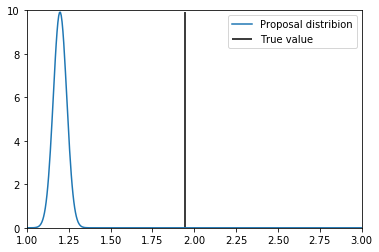

In [7]:
x = np.linspace(1,3,400)
y = norm.pdf(x,mu_val,np.exp(lg_sigma_val))

plt.plot(x,y,label="Proposal distribion")
plt.vlines(np.log(7),0,y.max(), label="True value")
plt.legend()

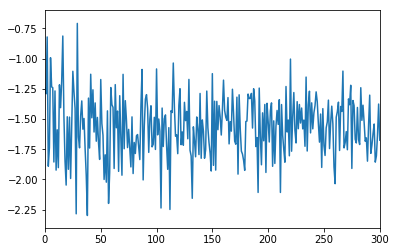

In [8]:
plt.plot(wgan_losses);